In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer,ToktokTokenizer
import re
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,recall_score,precision_score
from sklearn.naive_bayes import MultinomialNB
from string import punctuation
from nltk.stem import WordNetLemmatizer
import os
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
# Importing Dataframe
url = "https://raw.githubusercontent.com/ashlesha10/Women-s-E-Commerce-Clothing-Reviews/master/Data/Womens%20Clothing%20E-Commerce%20Reviews.csv" # Make sure the url is the raw version of the file on GitHub
data=pd.read_csv(url,index_col=0)
print(data.shape)
data.head()

(23486, 10)


,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [3]:
data = data[['Review Text','Recommended IND']]

In [4]:
data.rename(columns={'Review Text':'review_text','Recommended IND':'recommended'},inplace=True)

In [5]:
data.head(2)

,review_text,recommended
0,Absolutely wonderful - silky and sexy and comf...,1
1,Love this dress! it's sooo pretty. i happene...,1


In [6]:
data.isna().sum()


review_text    845
recommended      0
dtype: int64

In [7]:
data['review_text'] = data['review_text'].fillna(' ')

In [8]:
data.isna().sum()

review_text    0
recommended    0
dtype: int64

In [9]:
data.dtypes

review_text    object
recommended     int64
dtype: object

In [10]:
data.loc[data["recommended"] == 0, "recommended"] = "Not Recommended" # 0 -> Not Recommended
data.loc[data["recommended"] == 1, "recommended"] = "Recommended" # 1 -> Recommended

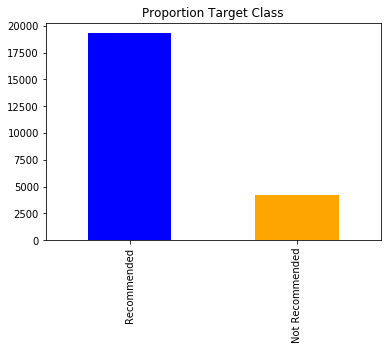

In [11]:
count_class=pd.value_counts(data["recommended"], sort= True)
count_class.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Proportion Target Class')
plt.show()

In [12]:
print('Recommended', round(data['recommended'].value_counts()['Recommended']/len(data) * 100), '%')
print('Not Recommended', round(data['recommended'].value_counts()['Not Recommended']/len(data) * 100), '%')

Recommended 82.0 %
Not Recommended 18.0 %


In [13]:
count1 = Counter(" ".join(data[data['recommended']== 'Recommended']['review_text']).\
                 split()).most_common(20)
df1 = pd.DataFrame.from_dict(count1)

In [14]:
df1 = df1.rename(columns={0: "common_words", 1 : "count"})
df1.head(10)

,common_words,count
0,the,58954
1,i,40789
2,and,40389
3,a,35828
4,it,29788
5,is,25523
6,to,19767
7,this,16676
8,in,16506
9,but,12601


In [15]:
count2 = Counter(" ".join(data[data['recommended']== 'Not Recommended']['review_text']).\
                 split()).most_common(20)
df2 = pd.DataFrame.from_dict(count2)

In [16]:
df2 = df2.rename(columns={0: "common_words", 1 : "count"})
df2.head(10)

,common_words,count
0,the,15744
1,i,8841
2,and,8116
3,it,7514
4,a,6804
5,is,4799
6,to,4547
7,was,4137
8,this,4050
9,in,3705


In [17]:
data.iloc[1,0]

'Love this dress!  it\'s sooo pretty.  i happened to find it in a store, and i\'m glad i did bc i never would have ordered it online bc it\'s petite.  i bought a petite and am 5\'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.'

In [18]:
tokenizer=ToktokTokenizer()
stopword_list=nltk.corpus.stopwords.words('english')
main_text = data['review_text']
target = data['recommended']

print(len(main_text))
print(len(target))

23486
23486


In [19]:
contractions_dict = {     
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I had",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "iit will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that had",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there had",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they had",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [20]:
def expand_contractions(text, contractions_dict):
    contractions_pattern = re.compile('({})'.format('|'.join(contractions_dict.keys())),
                                      flags=re.IGNORECASE | re.DOTALL)

    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contractions_dict.get(match) \
            if contractions_dict.get(match) \
            else contractions_dict.get(match.lower())
        expanded_contraction = expanded_contraction
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text
def cons(text):
    text=expand_contractions(text,contractions_dict)
    return text

main_text = main_text.apply(cons)

In [21]:
#Tolowercase
def to_lower(text):
    return ' '.join([w.lower() for w in word_tokenize(text)])

main_text = main_text.apply(to_lower)

In [22]:

def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
def strip_punctuation(s):
    return ''.join(c for c in s if c not in punctuation)

main_text = main_text.apply(remove_special_characters)
main_text = main_text.apply(strip_punctuation)

In [23]:
from nltk.corpus import wordnet

In [24]:
def replaceElongated(word):
    repeat_regexp = re.compile(r'(\w*)(\w)\2(\w*)')
    repl = r'\1\2\3'
    if wordnet.synsets(word):
        return word
    repl_word = repeat_regexp.sub(repl, word)
    if repl_word != word:      
        return replaceElongated(repl_word)
    else:       
        return repl_word
main_text = main_text.apply(replaceElongated)

In [25]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

main_text = main_text.apply(lambda x: tokenizer.tokenize(x))

In [26]:
def remove_stopwords(text):
    words = [w for w in text if w not in stopword_list]
    return words

main_text = main_text.apply(lambda x : remove_stopwords(x))

In [27]:
from nltk.stem import SnowballStemmer

snowball_stemmer = SnowballStemmer('english')

def stem_update(text_list):
    text_list_new = []
    for word in text_list:
        word = snowball_stemmer.stem(word)
        text_list_new.append(word)
    return text_list_new
main_text = main_text.apply(stem_update)

In [28]:
def drop_numbers(list_text):
    list_text_new = []
    for i in list_text:
        if not re.search('\d', i):
            list_text_new.append(i)
    return ' '.join(list_text_new)
main_text = main_text.apply(drop_numbers)

In [29]:
df = pd.concat([main_text,target],axis=1)

In [30]:
df.head(2)

,review_text,recommended
0,absolut wonder silki sexi comfort,Recommended
1,love dres preti hapen find store glad bc never...,Recommended


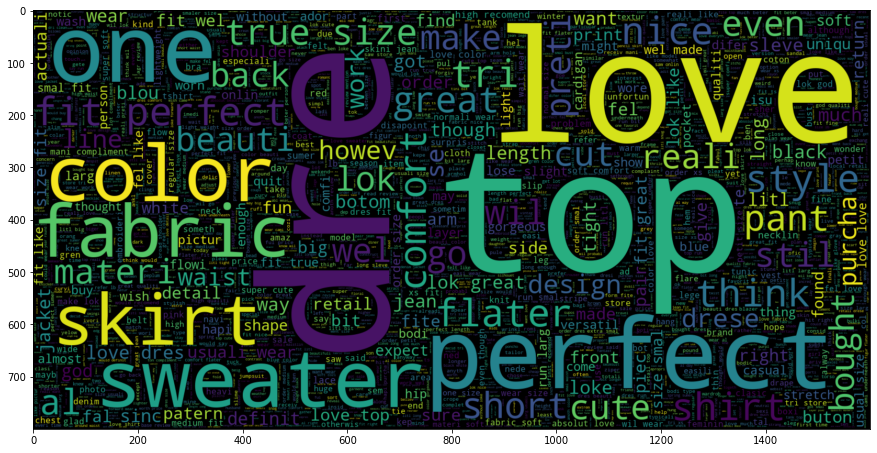

In [31]:
plt.figure(figsize = (15,15)) # Text that is recommended
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(df[df.recommended == 'Recommended'].review_text))
plt.imshow(wc , interpolation = 'bilinear')

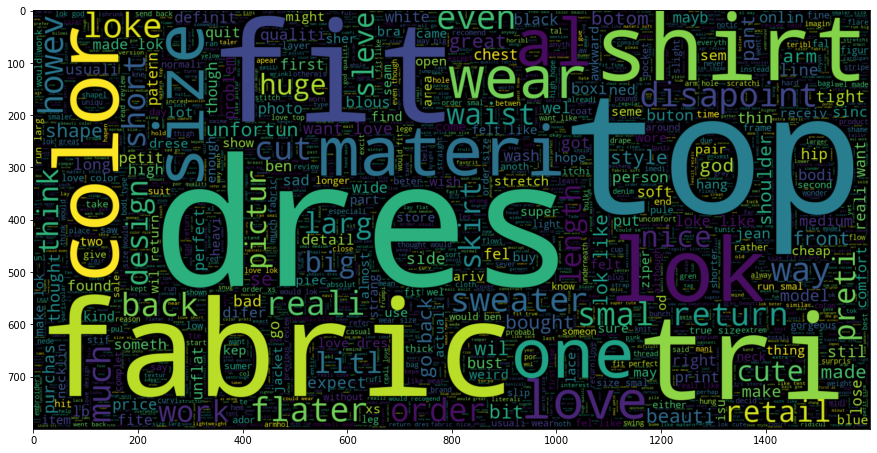

In [32]:
plt.figure(figsize = (15,15)) # Text that is not recommended
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(df[df.recommended == 'Not Recommended'].review_text))
plt.imshow(wc , interpolation = 'bilinear')

In [33]:
cv=CountVectorizer()


train_data,test_data = train_test_split(df,train_size=0.8,random_state=0)

X_train = cv.fit_transform(train_data['review_text'])
y_train = train_data['recommended']
X_test = cv.transform(test_data['review_text'])
y_test = test_data['recommended']

In [34]:
print(X_train.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [39]:
nb = MultinomialNB()
nb.fit(X_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [40]:
nb_predict=nb.predict(X_test)

In [41]:
nb_report = accuracy_score(y_test,nb_predict)
print('Accuracy:',nb_report)

Accuracy: 0.8914431673052363


In [42]:
print(confusion_matrix(y_test, nb_predict ))
print(classification_report(y_test, nb_predict ))

[[ 519  309]
 [ 201 3669]]
                 precision    recall  f1-score   support

Not Recommended       0.72      0.63      0.67       828
    Recommended       0.92      0.95      0.94      3870

       accuracy                           0.89      4698
      macro avg       0.82      0.79      0.80      4698
   weighted avg       0.89      0.89      0.89      4698



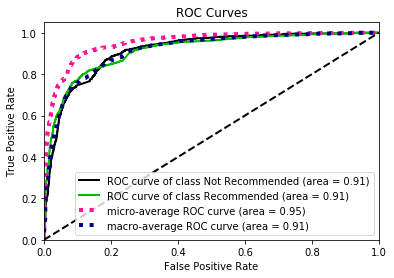

In [43]:
skplt.metrics.plot_roc(y_test, nb.predict_proba(X_test)) 